# Import Model

In [14]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.act1  = nn.SiLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.shortcut = None
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        self.act2 = nn.SiLU()

    def forward(self, x):
        identity = x
        out = self.act1(self.bn1(self.conv1(x)))
        out = self.act2(self.bn2(self.conv2(out)))
        if self.shortcut is not None:
            identity = self.shortcut(x)
        return out + identity



class DeepTileEncoder(nn.Module):
    """加深的 Tile 分支：全局信息，多尺度池化 + 三层 MLP"""
    def __init__(self, out_dim, in_channels=3, negative_slope=0.01):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(),
            nn.MaxPool2d(2)  # 78→39
        )
        self.layer1 = nn.Sequential(
            ResidualBlock(32, 64),
            ResidualBlock(64, 64),
            nn.MaxPool2d(2)  # 39→19
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128),
            ResidualBlock(128, 128),
            nn.MaxPool2d(2)  # 19→9
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(128, 256),
            ResidualBlock(256, 256)
        )  # 保持 9×9

        # 多尺度池化
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # [B,256,1,1]
        self.mid_pool    = nn.AdaptiveAvgPool2d((3, 3))  # [B,256,3,3]

        total_dim = 256*1*1 + 256*3*3
        # 三层 MLP：total_dim → 2*out_dim → out_dim → out_dim
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.1),
            nn.Linear(total_dim, out_dim*4),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(out_dim*4, out_dim*2),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(out_dim*2, out_dim),
            nn.LeakyReLU(negative_slope),
        )

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # x: [B,256,9,9]
        g = self.global_pool(x).contiguous().reshape(x.size(0), -1)  # [B,256]
        m = self.mid_pool(x).contiguous().reshape(x.size(0), -1)     # [B,256*3*3]

        return self.fc(torch.cat([g, m], dim=1))


class SubtileEncoder(nn.Module):
    """多尺度 Subtile 分支：局部信息 + 两层 MLP"""
    def __init__(self, out_dim, in_channels=3, negative_slope=0.01):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(),
            nn.MaxPool2d(2)  # 26→13
        )
        self.layer1 = nn.Sequential(
            ResidualBlock(32, 64),
            ResidualBlock(64, 64),
            nn.MaxPool2d(2)  # 13→6
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128),
            ResidualBlock(128, 128)
        )  # 保持 6×6

        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.mid_pool    = nn.AdaptiveAvgPool2d((2,2))
        self.large_pool    = nn.AdaptiveAvgPool2d((3,3))

        total_dim = 128*1*1 + 128*2*2 + 128*3*3
        # 两层 MLP：total_dim → out_dim*2 → out_dim
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.1),
            nn.Linear(total_dim, out_dim*2),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(out_dim*2, out_dim),
            nn.LeakyReLU(negative_slope),
        )

    def forward(self, x):
        B, N, C, H, W = x.shape
        x = x.contiguous().reshape(B*N, C, H, W)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        # g,m: [B*N, feat]
        g = self.global_pool(x).contiguous().reshape(B, N, -1)
        m = self.mid_pool(x).contiguous().reshape(B, N, -1)
        l = self.large_pool(x).contiguous().reshape(B, N, -1)

        # 合并 N 张 subtiles，再 FC
        feat = torch.cat([g, m, l], dim=2).mean(dim=1).contiguous()  # [B, total_dim]
        return self.fc(feat)
class CenterSubtileEncoder(nn.Module):
    """專門處理中心 subtile 的 Encoder"""
    def __init__(self, out_dim, in_channels=3, negative_slope= 0.01):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(),
            nn.MaxPool2d(2)  # 26→13
        )
        self.layer1 = nn.Sequential(
            ResidualBlock(32, 64),
            ResidualBlock(64, 64),
            nn.MaxPool2d(2)  # 13→6
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128),
            ResidualBlock(128, 128)
        )  # 6×6

        # 多尺度池化
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.mid_pool    = nn.AdaptiveAvgPool2d((2,2))
        self.large_pool    = nn.AdaptiveAvgPool2d((3,3))

        total_dim = 128*1*1 + 128*2*2 + 128*3*3
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.1),
            nn.Linear(total_dim, out_dim*2),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(out_dim*2, out_dim),
            nn.LeakyReLU(negative_slope),
        )

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        g = self.global_pool(x).contiguous().reshape(x.size(0), -1)
        m = self.mid_pool(x).contiguous().reshape(x.size(0), -1)
        l = self.large_pool(x).contiguous().reshape(x.size(0), -1)

        return self.fc(torch.cat([g, m, l], dim=1)).contiguous()


class VisionMLP_MultiTask(nn.Module):
    """整體多任務模型：融合 tile + subtile + center + position 特徵"""
    def __init__(self, tile_dim=128, subtile_dim=128, output_dim=35, negative_slope=0.01):
        super().__init__()
        self.encoder_tile    = DeepTileEncoder(tile_dim)
        self.encoder_subtile = SubtileEncoder(subtile_dim)
        self.encoder_center  = CenterSubtileEncoder(subtile_dim)

        self.feature_dim = tile_dim + subtile_dim + subtile_dim # +2 for position(x,y)

        self.decoder = nn.Sequential(
            nn.Linear(self.feature_dim, 256),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(64, output_dim),
        )

    def forward(self, tile, subtiles):
        tile = tile.contiguous()
        subtiles = subtiles.contiguous()
        center = subtiles[:, 4]

        f_tile = self.encoder_tile(tile)         # [B, tile_dim]
        f_sub  = self.encoder_subtile(subtiles)  # [B, subtile_dim]
        f_center = self.encoder_center(center)   # [B, subtile_dim]

        # 拼接特徵向量與座標
        features_cat = torch.cat([f_tile, f_sub, f_center], dim=1)  # [B, tile+sub+center+2]

        return self.decoder(features_cat)


# 用法示例
model = VisionMLP_MultiTask(tile_dim=128, subtile_dim=128, output_dim=35)


# —— 5) 确保只有 decoder 可训练 ——  
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total     = sum(p.numel() for p in model.parameters())
print(f"Trainable / total params = {trainable:,} / {total:,}")

Trainable / total params = 6,679,843 / 6,679,843


## Load Model

In [ ]:

from python_scripts.import_model import load_model_classes
from python_scripts.operate_model import get_model_inputs

# ==============================================
# 範例使用
# ==============================================
folder = "./output_folder/CNN+MLP/"  # 替換成實際的資料夾路徑，該路徑下應有 model.py
try:
    loaded_classes = load_model_classes(folder)
    print("載入的 class 名稱:", list(loaded_classes.keys()))
except Exception as e:
    print("載入模型 class 發生錯誤:", e)    


In [ ]:
# 假設 loaded_classes 是你已經從 model.py 載入的 class 字典
name_of_class = 'VisionMLPModelWithCoord'
ModelClass = loaded_classes.get(name_of_class)
if ModelClass is None:
    raise ValueError(f"找不到 {name_of_class} 這個 class")
# 這裡呼叫 ModelClass() 建立實例，注意不能直接用 name_of_class() (因為它是一個字串)
model = ModelClass()  # 如果需要參數，請在此處傳入
get_model_inputs(model)
#print("建立的模型實例:", model)


# Import training data

## Same in multiple .pt

In [3]:
import os
import torch
import random
import inspect
from python_scripts.import_data import load_all_tile_data

# 用法範例
folder = "dataset/spot-rank/filtered_directly_rank/masked/realign/Macenko_4_7_masked/filtered/train_data/"
grouped_data = load_all_tile_data( 
        folder_path=folder,
        model=model,
        fraction=1,
        shuffle=True
    )

    # grouped_data 現在只會有 model.forward() 需要的 key，
    # 像 ['tile','subtiles','neighbors','norm_coord','node_feat','adj_list','edge_feat','label','source_idx']
print("Loaded keys:", grouped_data.keys())
print("Samples:", len(next(iter(grouped_data.values()))))


In [6]:
from python_scripts.import_data import importDataset

image_keys = [ 'tile', 'subtiles']

train_dataset = importDataset(
        data_dict=grouped_data,
        model=model,
        image_keys=image_keys,
        transform=lambda x: x,  # identity transform
        print_sig=True
    )

Model forward signature: (tile, subtiles)


In [5]:
train_dataset.check_item(13, 10)


Model forward signature: (tile, subtiles)


In [8]:

from torch.utils.data import random_split
from torch.utils.data import DataLoader

# 設定比例
train_ratio = 0.8
val_ratio = 1 - train_ratio
total_len = len(train_dataset)
train_len = int(train_ratio * total_len)
val_len = total_len - train_len

# 拆分 Dataset
generator = torch.Generator().manual_seed(42)
train_set, val_set = random_split(train_dataset, [train_len, val_len], generator=generator)

print(f"✅ Train: {len(train_set)} samples")
print(f"✅ Val: {len(val_set)} samples")

# 🔹 將其包成 DataLoader
BATCH_SIZE = 32

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)


✅ Train: 6455 samples
✅ Val: 1614 samples


# Save in one pt

In [9]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
from python_scripts.import_data import importDataset, preprocess_data
from torch.utils.data import DataLoader
from torchvision import transforms

# 載入資料
#tile = torch.load("./dataset/final_data/M_tiles.pt")
#subtiles = torch.load("./train_dataset_sep_v2/subtiles.pt")
#neighbor_tiles = torch.load("./train_dataset_sep_v2/neighbor_tiles.pt")
#label = torch.load("./dataset/final_data/gu_log2_labels.pt")
#meta = torch.load("./dataset/final_data/meta_info.pt")



raw_coords = []
for _meta in grouped_data['coords']:
    if _meta is not None:
         x, y = _meta
    else:
        x, y = 0, 0
    raw_coords.append([x, y])

raw_coords = np.array(raw_coords)


coord_scaler = StandardScaler()
normalized_coords = coord_scaler.fit_transform(raw_coords)

train_dataset = {
        'tile': tile,
        #'subtiles': subtiles,
        #'neighbor_tiles': neighbor_tiles,
        'coords': normalized_coords,
        'label': label
    }

my_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])

image_keys = ['tile']

#processed_data = preprocess_data(train_dataset, image_keys, my_transform)

train_dataset = importDataset(
        data_dict=train_dataset,
        model=model,
        image_keys=image_keys,
        transform=lambda x: x,  # identity transform
        print_sig=True
    )

KeyError: 'coords'

In [ ]:
train_dataset = importDataset(
        data_dict=processed_data,
        model=model,
        image_keys=image_keys,
        transform=lambda x: x,  # identity transform
        print_sig=True
        )

In [ ]:
train_dataset.check_item(1000, 10)


In [21]:
from torch.utils.data import random_split

# 設定比例
train_ratio = 0.8
val_ratio = 1 - train_ratio
total_len = len(train_dataset)
train_len = int(train_ratio * total_len)
val_len = total_len - train_len

# 拆分 Dataset
generator = torch.Generator().manual_seed(42)
train_set, val_set = random_split(train_dataset, [train_len, val_len], generator=generator)

print(f"✅ Train: {len(train_set)} samples")
print(f"✅ Val: {len(val_set)} samples")

# 🔹 將其包成 DataLoader
BATCH_SIZE = 32

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)


✅ Train: 6678 samples
✅ Val: 1670 samples


#  Train model

In [12]:
import os
import torch
import csv
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from python_scripts.operate_model import train_one_epoch, evaluate, predict, EarlyStopping, plot_losses, plot_per_cell_metrics
import torch.nn as nn

# ---------------------------
# 指定儲存資料夾
# ---------------------------
save_folder = "/Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/whole_worflow/filtered_directly_rank/k-fold_mix/realign/4_7/Macenko_masked"  # 修改為你想要的資料夾名稱
if not os.path.exists(save_folder):
    os.makedirs(save_folder)


In [10]:
import torch
import inspect
from python_scripts.operate_model import get_model_inputs
import numpy as np
from python_scripts.import_data import load_node_feature_data


image_keys = [ 'tile', 'subtiles']


# 用法示例
from python_scripts.import_data import importDataset
# 假设你的 model 已经定义好并实例化为 `model`
test_dataset = load_node_feature_data("dataset/spot-rank/filtered_directly_rank/masked/test/Macenko_4_7/test_dataset.pt", model)
print(test_dataset.keys())
test_dataset = importDataset(
        data_dict=test_dataset,
        model=model,
        image_keys=image_keys,
        transform=lambda x: x,  # identity transform
        print_sig=True
    )

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
import h5py
import pandas as pd

# ==== 讀取 test spot index 用於對應 ID ====
with h5py.File("./dataset/elucidata_ai_challenge_data.h5", "r") as f:
    test_spots = f["spots/Test"]
    test_spot_table = pd.DataFrame(np.array(test_spots['S_7']))  # Example: S_7

/Users/deweywang/Desktop/GitHub/HEVisum/python_scripts/import_data.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw = torch.load(pt_path, map_location="cpu")


⚠️ 從 '<class 'list'>' 推斷樣本數量: 2088
dict_keys(['tile', 'subtiles', 'source_idx', 'position', 'label'])
Model forward signature: (tile, subtiles)


✅ Epoch 024: model → /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/whole_worflow/filtered_directly_rank/k-fold_mix/realign/4_7/Macenko_masked/results/model_epoch024.pt
✅ Epoch 024: preds → /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/whole_worflow/filtered_directly_rank/k-fold_mix/realign/4_7/Macenko_masked/results/submission_epoch024.csv
Epoch 24/500 | loss: 37.3660 | val_loss: 37.6570 | lr: 1.00e-04
train spearman: 0.8019 | Val spearman: 0.7840 | ρ: 0.7840


<Figure size 640x480 with 0 Axes>

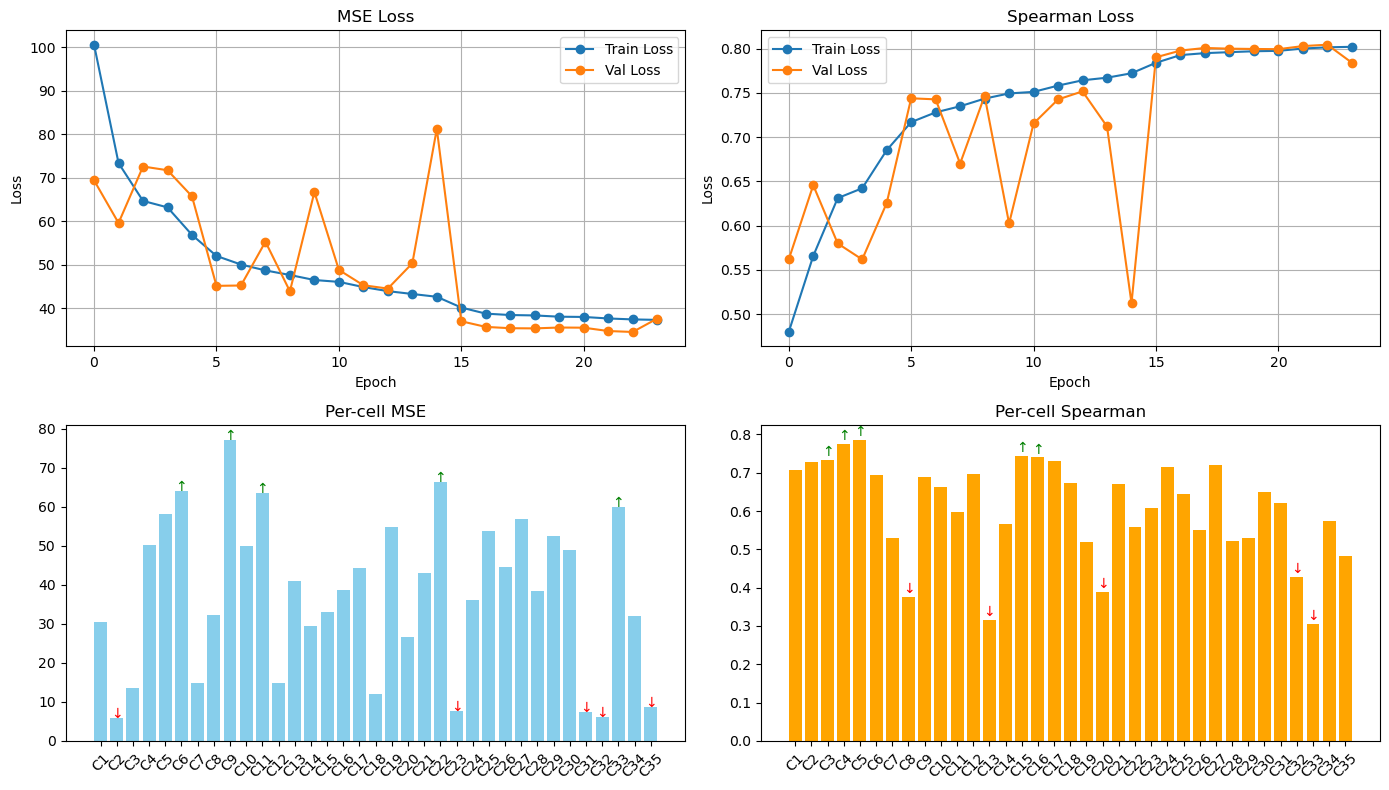

曲線圖已儲存至 /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/realign/whole_worflow/filtered_directly_rank/k-fold_mix/realign/4_7/Macenko_masked/loss_curve.png
EarlyStopping counter: 1/10


KeyboardInterrupt: 

In [15]:
# ---------------------------
# 🔧 設定裝置
# ---------------------------
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"✅ Using device: {device}")

# ---------------------------
# 初始化模型 & 優化器
# ---------------------------
model = model.to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#loss_fn = lambda pred, tgt: hybrid_weighted_spearman_loss(pred, tgt, alpha=0.5, beta=1.0)

#loss_fn = nn.MSELoss()
# loss_fn = spearman_loss
#LOSS_TYPE = "weighted_mse"  # 或 "mse", "mae", "spearman"

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
early_stopper = EarlyStopping(patience=10)

# ---------------------------
# 儲存 log 的設定
# ---------------------------
log_path = os.path.join(save_folder, "training_log.csv")
log_file = open(log_path, mode="w", newline="")
csv_writer = csv.writer(log_file)
csv_writer.writerow(["Epoch", "Train Loss", "Val Loss", "Val Spearman", "Learning Rate"])

# ---------------------------
# 用來畫圖的變數
# ---------------------------
train_losses = []
val_losses = []
train_spearmanes = []
val_spearmanes = []

# ---------------------------
# 指定最佳模型儲存路徑
# ---------------------------
best_model_path = os.path.join(save_folder, "best_model.pt")
loss_plot_path = os.path.join(save_folder, "loss_curve.png")

# ---------------------------
# 開始訓練
# ---------------------------
num_epochs = 500
best_val_loss = 0
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
display(fig)  # 初始顯示圖形
results_dir = os.path.join(save_folder, "results")
os.makedirs(results_dir, exist_ok=True)

for epoch in range(num_epochs):
    train_loss, train_spearman = train_one_epoch(model, train_loader, optimizer, device,current_epoch= epoch,initial_alpha=0, final_alpha=0, target_epoch = 15 )
    val_loss, val_spearman, mse_per_cell, spearman_per_cell = evaluate(model, val_loader, device, current_epoch= epoch,initial_alpha=0, final_alpha=0,target_epoch =15)
    clear_output(wait=True)  # 清除之前的輸出
    axes[0][0].clear()
    axes[0][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    # 儲存最佳模型
     # 1) 保存模型
    epoch_model_path = os.path.join(results_dir, f"model_epoch{epoch+1:03d}.pt")
    torch.save(model.state_dict(), epoch_model_path)

    # 2) 在 test 集上做预测
    model.eval()
    test_preds = predict(model, test_loader, device)

    # 3) 组装 submission DataFrame
    df = pd.DataFrame(
        test_preds,
        columns=[f"C{i+1}" for i in range(test_preds.shape[1])]
    )
    df.insert(0, "ID", test_spot_table.index)

    # 4) 保存预测结果
    pred_path = os.path.join(results_dir, f"submission_epoch{epoch+1:03d}.csv")
    df.to_csv(pred_path, index=False)

    print(f"✅ Epoch {epoch+1:03d}: model → {epoch_model_path}")
    print(f"✅ Epoch {epoch+1:03d}: preds → {pred_path}")
        

    # 調整學習率
    scheduler.step(val_loss)

    # 寫入 CSV log
    lr = optimizer.param_groups[0]['lr']
    csv_writer.writerow([epoch + 1, train_loss, val_loss, val_spearman, lr])

    # 印出 Epoch 結果
    print(f"Epoch {epoch + 1}/{num_epochs} | loss: {train_loss:.4f} | val_loss: {val_loss:.4f} | lr: {lr:.2e}")
    print(f"train spearman: {train_spearman:.4f} | Val spearman: {val_spearman:.4f} | ρ: {val_spearman:.4f}")

    # 更新 log 列表並畫圖
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_spearmanes.append(train_spearman)
    val_spearmanes.append(val_spearman)
    


    # plot loss
    plot_losses(train_losses, val_losses, ax=axes[0][0], title="MSE Loss")
    plot_losses(train_spearmanes, val_spearmanes, ax=axes[0][1], title="Spearman Loss")

    cell_names = [f"C{i+1}" for i in range(35)]
    # plot per-cell stats
    plot_per_cell_metrics(mse_per_cell, spearman_per_cell,cell_names,
                        ax_mse=axes[1][0], ax_spearman=axes[1][1])
    

    plt.tight_layout()
    plt.show()
    display(fig)
    plt.pause(0.1)  # 暫停以便更新畫面
    fig.savefig(loss_plot_path)
    print(f"曲線圖已儲存至 {loss_plot_path}")

    # Early stopping
    early_stopper(val_loss)
    if early_stopper.early_stop:
        print("⛔ Early stopping triggered.")
        break

# 關閉 CSV log 檔案
log_file.close()

# 儲存最終圖形
plt.close(fig)
print(f"訓練結束，loss 曲線圖已儲存至 {loss_plot_path}")



# Integrated Gradient

In [ ]:
from typing import Dict
import torch
import numpy as np
import pandas as pd
from captum.attr import IntegratedGradients
from python_scripts.operate_model import get_model_inputs

def automate_ig_all_targets(model,
                            batch,
                            n_cells: int = 35,
                            n_steps: int = 50,
                            n_runs: int = 20,
                            baseline_stdevs: Dict[str, float] = None):
    """
    对每个输出 t∈[0,n_cells):
      - 在 n_runs 个随机 baseline 上跑 IG
      - 对图像输入噪声范围 [0,1]*stdev_img；对坐标噪声范围 [-1,1]*stdev_coord
      - 计算 mean|IG| & std|IG|，并打印
    最终返回一个 DataFrame，行是 cell，列是每个输入的 mean±std。
    """
    cpu = torch.device("cpu")
    model_cpu = model.to(cpu).float().eval()
    sig = get_model_inputs(model_cpu, print_sig=False)
    param_names = [p for p in sig.parameters if p != "self"]
    # 只保留 tensor
    tensor_names = [n for n in param_names if isinstance(batch[n], torch.Tensor)]

    # 默认各自 stdev
    baseline_stdevs = baseline_stdevs or {}
    # e.g. {"tile": 0.1, "subtiles": 0.1, "neighbors": 0.1, "norm_coord": 0.2}

    # 预先把 inputs 拷贝到 CPU, 取第 1 样本
    inputs_cpu = []
    for n in tensor_names:
        x = batch[n].detach().cpu().float()[0:1].requires_grad_(True)
        inputs_cpu.append(x)

    ig = IntegratedGradients(model_cpu)
    results = {t: {n: [] for n in tensor_names} for t in range(n_cells)}

    for t in range(n_cells):
        print(f"\n=== Cell C{t+1} / {n_cells} ===")
        for run in range(n_runs):
            baselines = []
            for name, inp in zip(tensor_names, inputs_cpu):
                stdev = baseline_stdevs.get(name, 0.1)
                if name == "norm_coord":
                    # 坐标范围 [-1,1]
                    noise = (torch.rand_like(inp) * 2 - 1) * stdev
                else:
                    # 图像范围 [0,1]
                    noise = torch.rand_like(inp) * stdev
                baselines.append(noise)
            attributions = ig.attribute(
                inputs=tuple(inputs_cpu),
                baselines=tuple(baselines),
                target=t,
                n_steps=n_steps,
                internal_batch_size=1
            )
            for name, attr in zip(tensor_names, attributions):
                results[t][name].append(attr.abs().mean().item())

        # 打印这一 cell 的 mean±std
        for name in tensor_names:
            arr = np.array(results[t][name], dtype=np.float32)
            print(f"  {name:12s}: {arr.mean():.4f} ± {arr.std():.4f}")

    # 汇总到 DataFrame
    rows = []
    for t in range(n_cells):
        row = {"cell": f"C{t+1}"}
        for name in tensor_names:
            arr = np.array(results[t][name], dtype=np.float32)
            row[f"{name}_mean"] = arr.mean()
            row[f"{name}_std"]  = arr.std()
        rows.append(row)
    df = pd.DataFrame(rows).set_index("cell")
    return df
baseline_stdevs = {
    "tile":        0.15,
    "subtiles":    0.15,
    "neighbors":   0.22,
    "norm_coord":  0.37,
}
batch = next(iter(val_loader))

df_scores = automate_ig_all_targets(
    model, batch,
    n_cells=35, n_steps=50, n_runs=5,
    baseline_stdevs=baseline_stdevs)
display(df_scores.describe())



=== Cell C1 / 35 ===


KeyboardInterrupt: 

# Predict

In [9]:
# ===== 需要的 Libraries =====
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
import csv
import os

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"✅ Using device: {device}")
best_model_path = os.path.join(save_folder, "best_model.pt")
model = model.to(device)
print(f"✅ Loading model from {best_model_path}")
model.load_state_dict(torch.load('output_folder/rank-spot/CNN+Res+MLP_version-1/softrank/no_coords_neighbor/OG_10xtrain/results/model_epoch001.pt'))
model.eval()


✅ Using device: mps
✅ Loading model from /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/CNN+Res+MLP_version-1/softrank/no_coords_neighbor/OG_10xtrain_different loss/best_model.pt


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_11288/727690515.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('output_fold

VisionMLP_MultiTask(
  (encoder_tile): DeepTileEncoder(
    (layer0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): LeakyReLU(negative_slope=0.01)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential(
          (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [11]:
import torch
import inspect
from python_scripts.operate_model import get_model_inputs

def load_node_feature_data(pt_path: str, model, num_cells: int = 35) -> dict:
    """
    根据 model.forward 的参数自动加载 .pt 里对应的字段，
    并且如果没有 label，就自动创建一个全 0 的 label 张量，
    其尺寸为 (样本数, num_cells)，样本数从第一个有 __len__ 的输入推断。

    参数：
      pt_path:     str，.pt 文件路径
      model:       已实例化的 PyTorch 模型
      num_cells:   int，label 的列数（默认 35）

    返回：
      dict: key 对应模型 forward 中的参数名（不含 self），
            value 是对应的 Tensor/ndarray，
            并额外保证有 'label' 字段。
    """
    # 1) 载入原始数据
    raw = torch.load(pt_path, map_location="cpu")

    # 2) 取模型 forward 入参签名（不含 self）
    sig = inspect.signature(model.forward)
    param_names = [p for p in sig.parameters if p != "self"]

    out = {}
    for name in param_names:
        # a) 直接同名
        if name in raw:
            out[name] = raw[name]
            continue
        # b) 复数形式
        if name + "s" in raw:
            out[name] = raw[name + "s"]
            continue
        # c) 模糊匹配（下划线、复数或前后缀）
        cands = [k for k in raw if name in k or k in name]
        if len(cands) == 1:
            out[name] = raw[cands[0]]
            continue
        raise KeyError(f"无法找到 '{name}' 在 pt 文件中的对应字段，raw keys: {list(raw.keys())}")

    # 3) 用第一个支持 len() 的输入推断样本数
    dataset_size = None
    for v in out.keys():
        if hasattr(out[v], "__len__"):
            dataset_size = len(out[v])
            print(f"⚠️ 从 '{v}' 推断样本数量: {dataset_size}")
            break
    if dataset_size is None:
        raise RuntimeError("无法从任何输入中推断样本数量，请检查 pt 文件内容。")

    # 4) 自动补 label

    out["label"] = torch.zeros((dataset_size, num_cells), dtype=torch.float32)
    return out


image_keys = [ 'tile', 'subtiles']


# 用法示例
from python_scripts.import_data import importDataset
# 假设你的 model 已经定义好并实例化为 `model`
test_dataset = load_node_feature_data("dataset/spot-rank/version-1/only_tile_sub/test/test_dataset.pt", model)
test_dataset = importDataset(
        data_dict=test_dataset,
        model=model,
        image_keys=image_keys,
        transform=lambda x: x,  # identity transform
        print_sig=True
    )



/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_55826/333364545.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw = torch.load(pt_path, map_location="cpu")

⚠️ 从 'tile' 推断样本数量: 2088
Model forward signature: (tile, subtiles)


In [ ]:
import torch
from torch.utils.data import Dataset
import inspect
from python_scripts.import_data import importDataset, preprocess_data
from python_scripts.operate_model import get_model_inputs
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# 正確方式
import torch

def load_node_feature_data(pt_path):
    """
    Load a single .pt file containing node-feature data saved as a dict.

    Parameters:
        pt_path (str): Path to the .pt file.

    Returns:
        dict: A dictionary with keys:
            - 'tiles'
            - 'subtiles'
            - 'neighbor_tiles'
            - 'labels'
            - 'coords'
            - 'normal_coords'
            - 'node_feats'
            - 'adj_lists'
            - 'edge_feats'
    """
    # Load the saved checkpoint into CPU memory
    data = torch.load(pt_path, map_location="cpu")

    # 依照你當初儲存時的 key 取值
    return {
        'tile':           data.get('tiles'),
        'subtiles':        data.get('subtiles'),
        'neighbors':  data.get('neighbor_tiles'),
        'label':          np.zeros((len(data.get('tiles')), 35)),
        'norm_coord':   data.get('normal_coords'),
        'node_feat':      data.get('node_feat'),
        'adj_list':       data.get('adj_list'),
        'edge_feat':      data.get('edge_feat'),
    }

# 範例用法
if __name__ == "__main__":
    path = "./dataset/spot-rank/version-1/node_features_test/test_dataset.pt"
    test_dataset = load_node_feature_data(path)
    print("各欄位長度檢查：")
    for k, v in test_dataset.items():
        L = len(v) if hasattr(v, "__len__") else "N/A"
        print(f"  {k:15s}: type={type(v).__name__:10s}, length={L}")




image_keys = ['tile','subtiles', 'neighbors']



#processed_data = preprocess_data(test_dataset, image_keys, my_transform)

test_dataset = importDataset(
        data_dict=test_dataset,
        model=model,
        image_keys=image_keys,
        transform=lambda x: x,  # identity transform
        print_sig=True
    )


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_77211/2443631239.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(pt_path, map_location="cpu

各欄位長度檢查：
  tile           : type=list      , length=2088
  subtiles       : type=list      , length=2088
  neighbors      : type=list      , length=2088
  label          : type=ndarray   , length=2088
  norm_coord     : type=list      , length=2088
  node_feat      : type=list      , length=2088
  adj_list       : type=list      , length=2088
  edge_feat      : type=list      , length=2088
Model forward signature: (tile, subtiles, neighbors, norm_coord)


In [20]:

test_dataset.check_item(1000, 10)


🔍 Checking dataset sample: 1000
📏 tile shape: torch.Size([3, 78, 78]) | dtype: torch.float32 | min: 0.200, max: 1.000, mean: 0.729, std: 0.152
📏 subtiles shape: torch.Size([9, 3, 26, 26]) | dtype: torch.float32 | min: 0.200, max: 1.000, mean: 0.729, std: 0.152
📏 label shape: torch.Size([35]) | dtype: torch.float32 | min: 0.000, max: 0.000, mean: 0.000, std: 0.000
--- label head (前 10 個元素):
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
✅ All checks passed!


In [12]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
test_preds = predict(model, test_loader, device)
test_preds

array([[20.751282, 27.409618, 20.475952, ..., 16.473867, 10.63524 ,
        16.522833],
       [28.28952 , 25.783438, 28.325615, ..., 16.56291 , 18.361225,
        19.792606],
       [30.07747 , 26.32949 , 29.353094, ..., 15.344533, 17.66405 ,
        19.783829],
       ...,
       [30.561419, 22.81811 , 28.898396, ..., 15.121625, 13.212474,
        17.715654],
       [22.1566  , 27.60208 , 22.873594, ..., 16.661678,  9.739686,
        18.164803],
       [21.817904, 25.583475, 21.366322, ..., 15.80887 , 10.82187 ,
        17.938635]], dtype=float32)

In [14]:
import h5py

# ==== 讀取 test spot index 用於對應 ID ====
with h5py.File("./dataset/elucidata_ai_challenge_data.h5", "r") as f:
    test_spots = f["spots/Test"]
    test_spot_table = pd.DataFrame(np.array(test_spots['S_7']))  # Example: S_7

submission_path = os.path.join(save_folder, "submission-try1.csv")

ensemble_df = pd.DataFrame(test_preds, columns=[f"C{i+1}" for i in range(test_preds.shape[1])])
ensemble_df.insert(0, 'ID', test_spot_table.index)
ensemble_df.to_csv(submission_path, index=False)
print(f"✅ Saved submission.csv in {submission_path}")


✅ Saved submission.csv in /Users/deweywang/Desktop/GitHub/HEVisum/output_folder/rank-spot/CNN+Res+MLP_version-1/softrank/no_coords_neighbor/same_as_OG_try_again_v2/submission-try1.csv


In [ ]:
from python_scripts.revert_utils import (
    load_json_params,
    revert_log2_predictions,
)

#params = load_json_params(json_path="./dataset/spots-data/version-1/zscore_params.json")
#params = load_json_params('data preprocessing/spot data cleaning/zscore_params.json')

# 或還原 log2
params = load_json_params("dataset/spots-data/version-5/zscore_params.json")
restored = revert_log2_predictions(test_preds, params, add_constant=1)

restored

In [ ]:
import h5py

# ==== 讀取 test spot index 用於對應 ID ====
with h5py.File("./dataset/elucidata_ai_challenge_data.h5", "r") as f:
    test_spots = f["spots/Test"]
    test_spot_table = pd.DataFrame(np.array(test_spots['S_7']))  # Example: S_7

submission_path = os.path.join(save_folder, "submission.csv")

ensemble_df = pd.DataFrame(restored, columns=[f"C{i+1}" for i in range(restored.shape[1])])
ensemble_df.insert(0, 'ID', test_spot_table.index)
ensemble_df.to_csv(submission_path, index=False)
print(f"✅ Saved submission.csv in {submission_path}")
